In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares

In [4]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    plt.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        plt.title(title)
    plt.show()

[Sat, 04 Mar 2023 17:30:53] [INFO    ] [topostats] Extracting image from Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Sat, 04 Mar 2023 17:30:53] [INFO    ] [topostats] Loading image from : Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Sat, 04 Mar 2023 17:30:53] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Loaded image from : Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Sat, 04 Mar 2023 17:30:54] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Extracted channel Height
[Sat, 04 Mar 2023 17:30:54] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Pixel to nm scaling : 5.992138671875


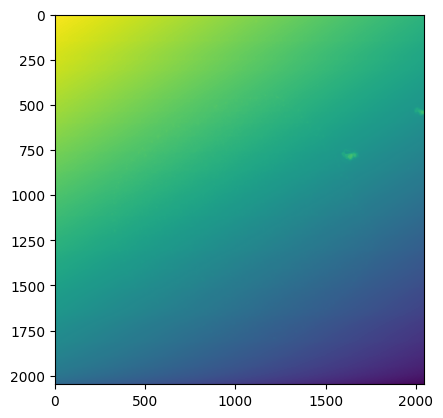

In [242]:
# file = Path('./Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm')
# file = Path('./Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm')
file = Path('./Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [243]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Sat, 04 Mar 2023 17:30:56] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : Median flattening without mask
[Sat, 04 Mar 2023 17:30:56] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : Plane tilt removal without mask
[Sat, 04 Mar 2023 17:30:56] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : x-polyfit 1st order: [-3.23236086e-02  3.28180535e+01]
[Sat, 04 Mar 2023 17:30:56] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : y-polyfit 1st order: [ 1.17049393e-19 -7.81666906e-17]
[Sat, 04 Mar 2023 17:30:56] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : Removing x plane tilt
[Sat, 04 Mar 2023 17:30:57] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : removing y plane tilt
[Sat, 04 Mar 2023 17:30:58] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : Remove quadra

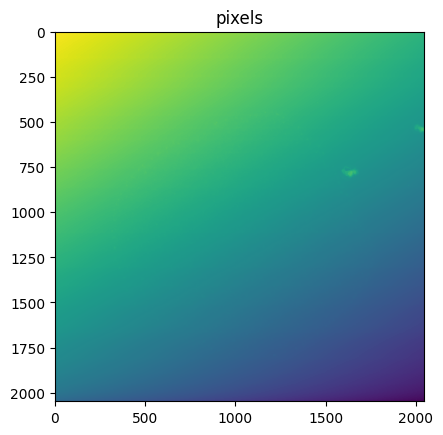

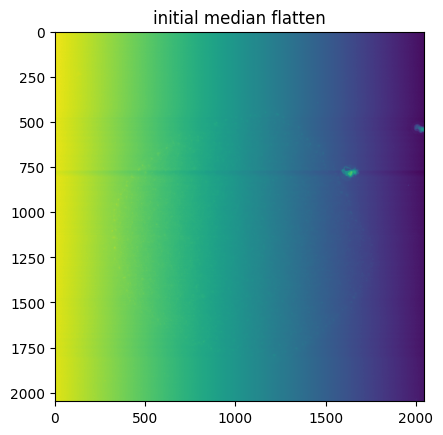

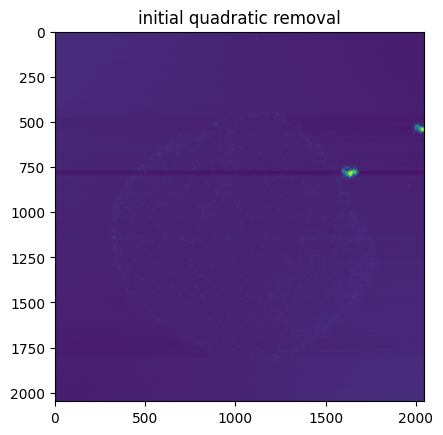

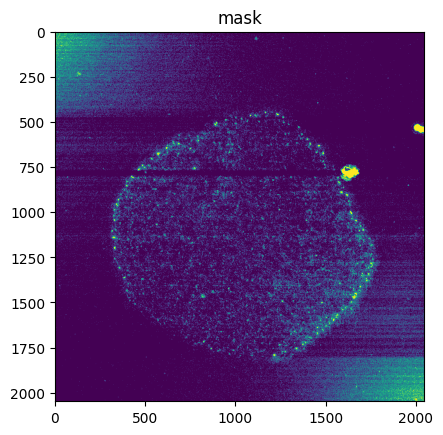

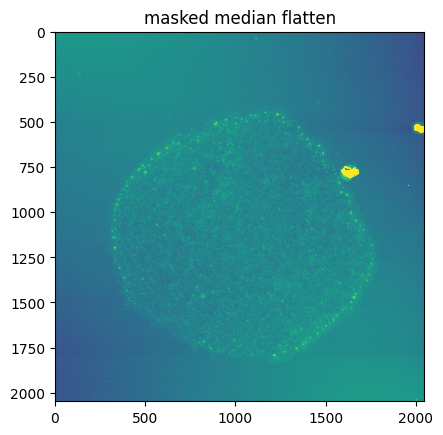

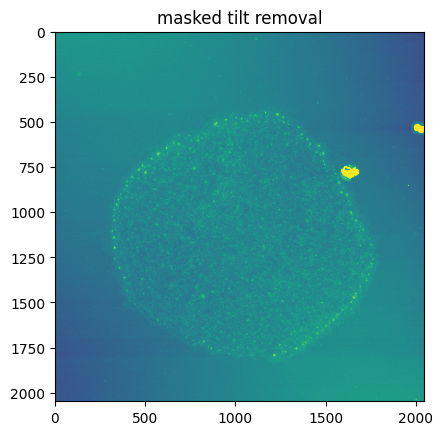

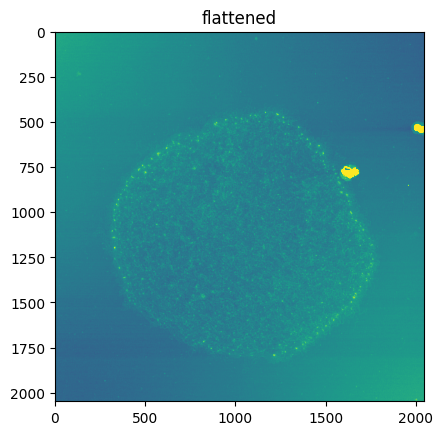

In [244]:
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 1.5992184373320717})
[Sat, 04 Mar 2023 17:31:10] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.5992184373320717


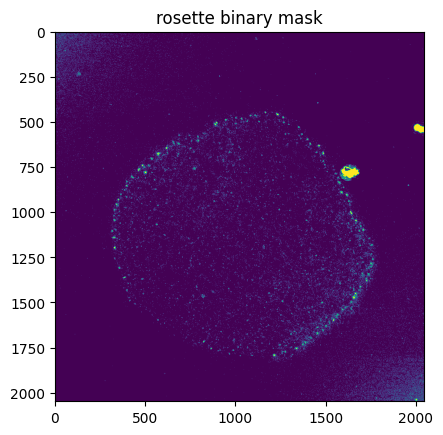

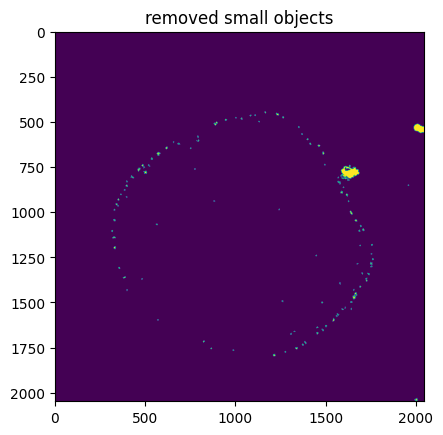

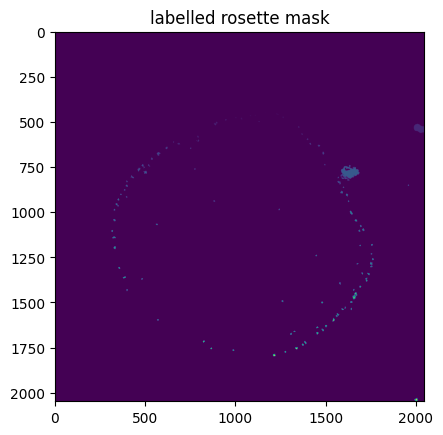

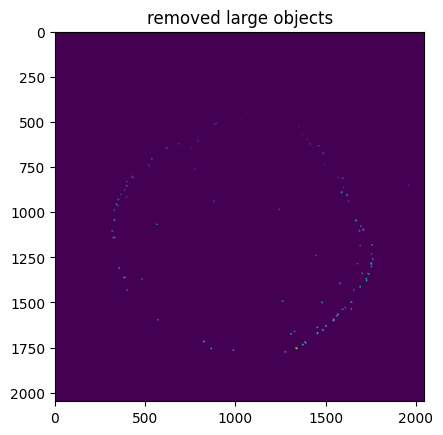

In [245]:
from skimage.morphology import remove_small_objects
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.5, 'lower': None}
)
print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask, title='rosette binary mask', zlimit=False)

# Remove small objects
rosette_mask = remove_small_objects(rosette_mask, 25)
plot(rosette_mask, title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(rosette_mask)
plot(labelled_rosette_mask, title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 100:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask, title='removed large objects', zlimit=False)


In [144]:
def ellipse_eqn(params, x, y):
    x0, y0, a, b, theta = params
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = ((x - x0) * cos_theta + (y - y0) * sin_theta) ** 2 / a ** 2
    ellipse_y = ((x - x0) * sin_theta - (y - y0) * cos_theta) ** 2 / b ** 2
    return ellipse_x + ellipse_y - 1

In [184]:
def fit_ellipse(x_data: np.ndarray, y_data: np.ndarray) -> np.ndarray:
    # Guess initial params for ellipse
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    x_range = np.max(x_data) - np.min(x_data)
    y_range = np.max(y_data) - np.min(y_data)
    a_guess = x_range / 2
    b_guess = y_range / 2
    params_guess = [x_mean, y_mean, a_guess, b_guess, 0]
    # Numerically find best fitting ellipse
    result = least_squares(ellipse_eqn, params_guess, args=(x_data, y_data))

    # x0, y0, a, b, theta = params
    return result.x

In [145]:
from skimage.measure import label, regionprops
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid
    y_data = points[:, 0]
    x_data = points[:, 1]

    return (y_data, x_data)

y_data, x_data = get_points(rosette_mask)

In [185]:
def fit_ellipse_remove_far_points(binary_image: np.ndarray, dist_stddev_thresh_multiplier: float) -> np.ndarray:
    y_data, x_data = get_points(binary_image)

    params = fit_ellipse(x_data, y_data)

    # Plot ellipse
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, 100)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = x0 + a * np.cos(t) * cos_theta - b * np.sin(t) * sin_theta
    ellipse_y = y0 + a * np.cos(t) * sin_theta + b * np.sin(t) * cos_theta
    fig_fit, ax_fit = plt.subplots(1, 2, figsize=(10, 5))
    ax_fit[0].scatter(x_data, y_data)
    ax_fit[0].plot(ellipse_x, ellipse_y)
    ax_fit[0].axis('equal')
    ax_fit[0].set_aspect(1)
    ax_fit[0].invert_yaxis()
    ax_fit[0].set_title('fitted ellipse')

    # Get distances of points from ellipse
    distances = np.array([ellipse_eqn(params, x_val, y_val) for x_val, y_val in zip(x_data, y_data)])
    dist_thresh = np.mean(distances) + dist_stddev_thresh_multiplier * np.std(distances)
    # Initialise image comparison plots
    fig_img, ax_img = plt.subplots(1, 3, figsize=(14, 5))

    # Plot residuals
    ax_fit[1].scatter(x_data, distances)
    ax_fit[1].set_xlim(0, 2000)
    ax_fit[1].axhline(y=dist_thresh, color='r', linestyle='-')
    ax_fit[1].axhline(y=-dist_thresh, color='r', linestyle='-')
    ax_fit[1].set_title('residuals')

    # Remove points too far from ellipse
    too_far_indicies = np.where(abs(distances) > dist_thresh)[0]
    too_far_indicies = np.add(too_far_indicies, 1) # Add one since the label indices start from one
    print(f'too far points: {too_far_indicies}')
    # Copy arrays for posterity
    removed_too_far_points = label(binary_image.copy())
    before_removal = removed_too_far_points.copy()
    # Remove too far points
    for index in too_far_indicies:
        removed_too_far_points[removed_too_far_points==index] = 0
        circle = plt.Circle((x_data[index-1], y_data[index-1]), 50, fill=False)
        ax_img[0].add_artist(circle)
        ax_fit[1].scatter(x_data[index-1], distances[index-1], marker='.', color='r') # Sub one since point indices start from zero
        ax_fit[0].scatter(x_data[index-1], y_data[index-1], marker='.', color='r')

    # Plot results
    ax_img[0].imshow(before_removal.astype(bool))
    ax_img[0].set_title('before')
    ax_img[1].imshow(removed_too_far_points.astype(bool))
    ax_img[1].set_title('removed too far points')
    ax_img[2].imshow((removed_too_far_points - before_removal).astype(bool))
    ax_img[2].set_title('difference')
    fig_img.suptitle(f'thresh={dist_stddev_thresh_multiplier}*std_dev + mean')
    fig_img.tight_layout()
    plt.show()

    return removed_too_far_points

too far points: [26 32 40 44 48 57 72]


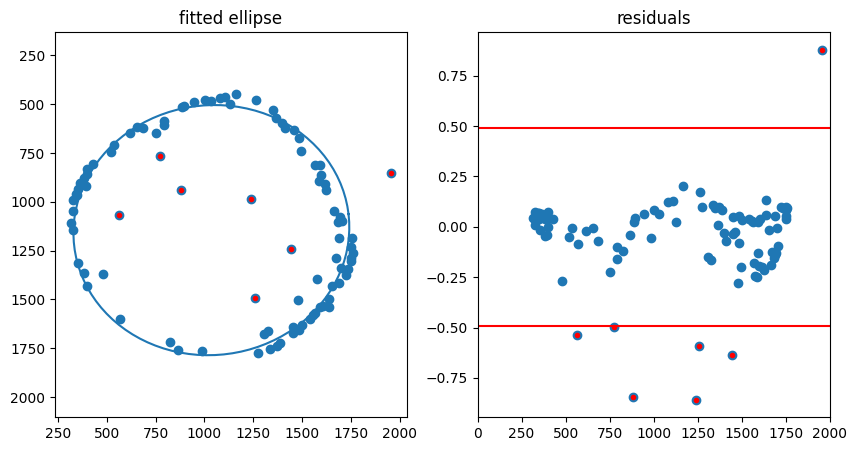

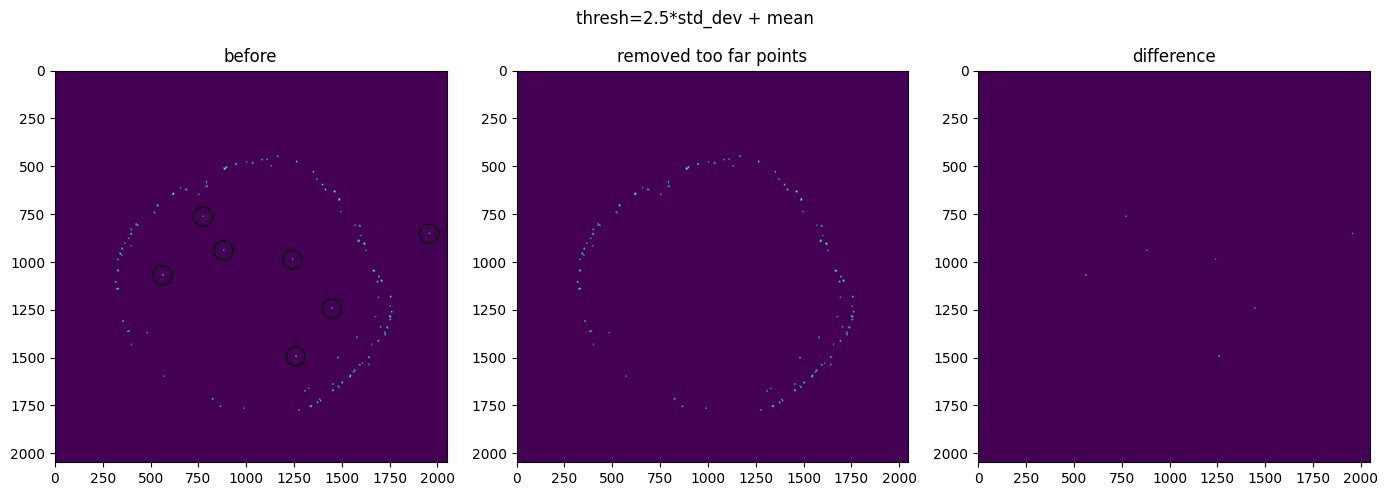

too far points: [ 1  4 15 21 61 62 67]


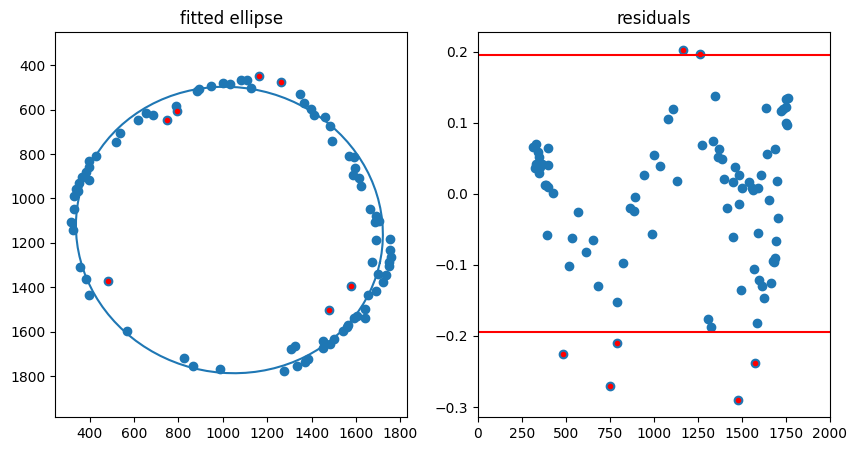

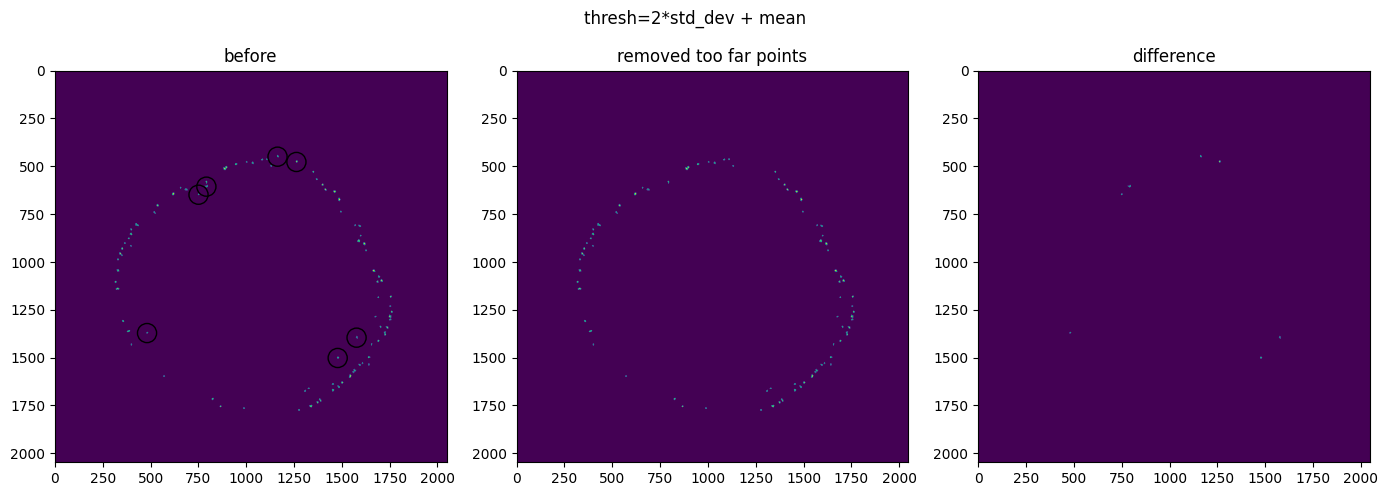

too far points: [ 1  2  9 11 14 20 21 29 30 34 39 48 51 71 73]


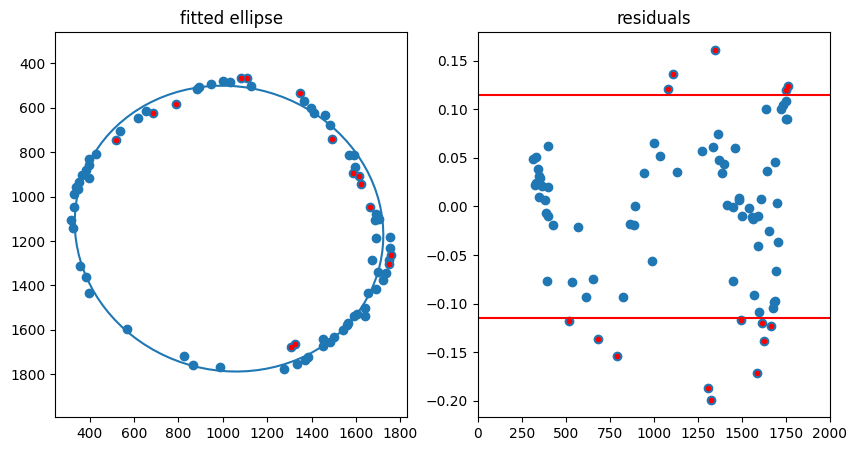

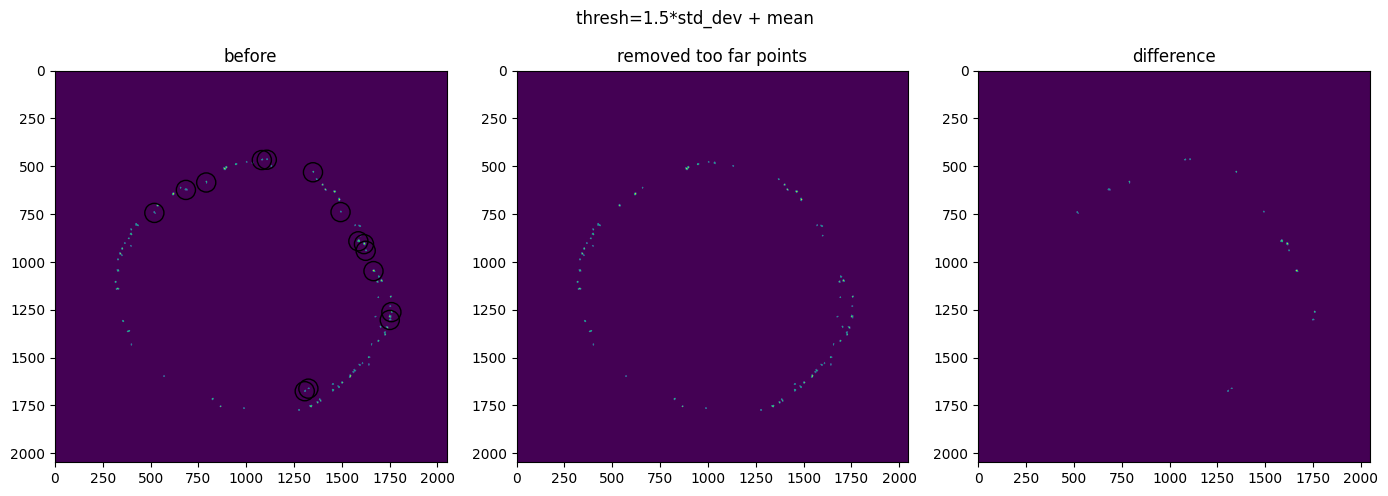

In [246]:
fitted_1 = fit_ellipse_remove_far_points(binary_image=labelled_rosette_mask, dist_stddev_thresh_multiplier=2.5)
fitted_2 = fit_ellipse_remove_far_points(binary_image=fitted_1, dist_stddev_thresh_multiplier=2)
fitted_3 = fit_ellipse_remove_far_points(binary_image=fitted_2, dist_stddev_thresh_multiplier=1.5)

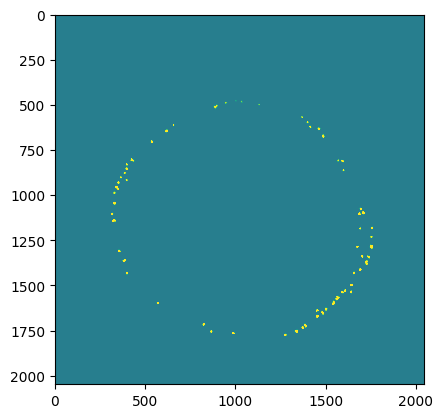

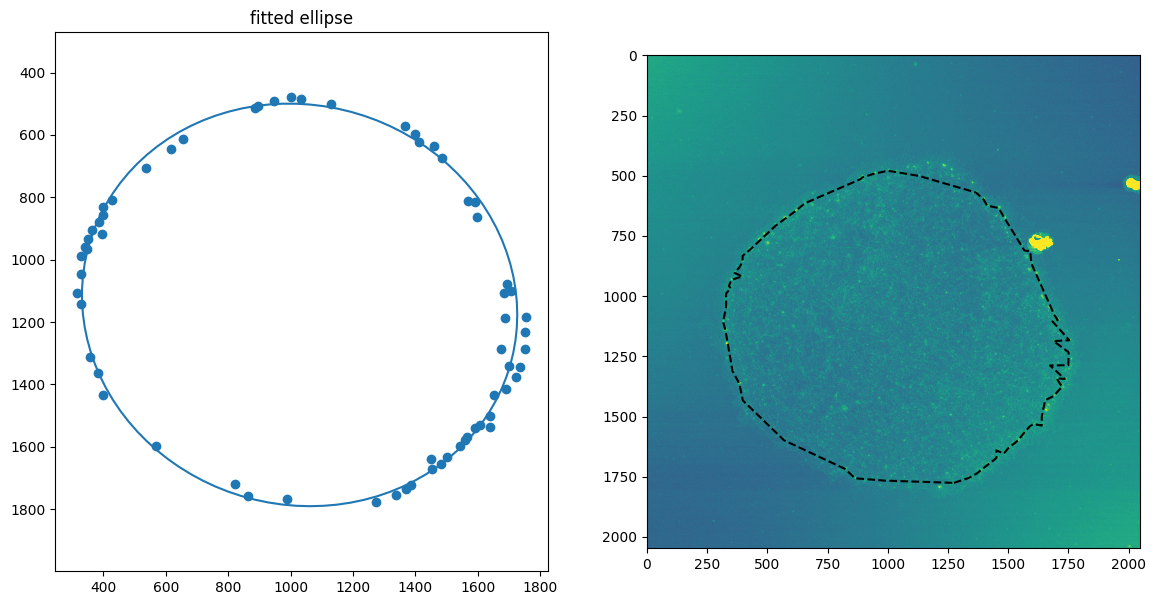

In [247]:
# Find the points in order
plot(fitted_3)

labelled = label(fitted_3)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid
y_data = points[:, 0]
x_data = points[:, 1]

params = fit_ellipse(x_data, y_data)
ellipse_distances = np.array([ellipse_eqn(params, x_val, y_val) for x_val, y_val in zip(x_data, y_data)])

# Plot ellipse
x0, y0, a, b, theta = params
t = np.linspace(0, 2 * np.pi, 100)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
ellipse_x = x0 + a * np.cos(t) * cos_theta - b * np.sin(t) * sin_theta
ellipse_y = y0 + a * np.cos(t) * sin_theta + b * np.sin(t) * cos_theta
fig_fit, ax_fit = plt.subplots(1, 2, figsize=(14, 7))
ax_fit[0].scatter(x_data, y_data)
ax_fit[0].plot(ellipse_x, ellipse_y)
ax_fit[0].axis('equal')
ax_fit[0].set_aspect(1)
ax_fit[0].invert_yaxis()
ax_fit[0].set_title('fitted ellipse')

# Calculate the centroid of the points
centroid = np.mean(points, axis=0)

# Function to find angle of point from centroid
def angle(point):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point) for point in points])]

# Plot the points
# ax_fit[1].scatter(sorted[:, 1], sorted[:, 0])

# # Draw text next to each point with its position in the array
# for i, point in enumerate(points):
#     ax.text(point[0] + 0.02, point[1] + 0.02, str(i), fontsize=12)

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

ax_fit[1].imshow(flattened, vmin=-3, vmax=4)
ax_fit[1].plot(xs, ys, 'k--')

plt.show()

# ordered_points = []
# visited_indices = []
# point_protection = 10
# iterations = 200

# # Set initial index to that of the point with least distance to the ellipse
# current_index = np.argmin(np.abs(ellipse_distances))
# initial_index = current_index

# ax_fit[0].scatter(points[current_index, 1], points[current_index, 0], color='k', marker='.')

# while (current_index != initial_index) and iterations < 200:
#     # Get current point
#     current_point = points[current_index]
#     # Add to ordered points
#     ordered_points.append(current_point)
#     # Calculate distances and set visited points to infinite
#     distances = np.linalg.norm(points - current_point, axis=1)
#     distances[visited_indices] = np.inf

#     nearest_point_index = np.argmin(distances)
#     current_index = nearest_point_index

# if iterations == 200:
#     print('DID NOT FIND ORIGINAL POINT')


outliers: [ 29  30  32  33  74  75  84 153 154 155 156 157]


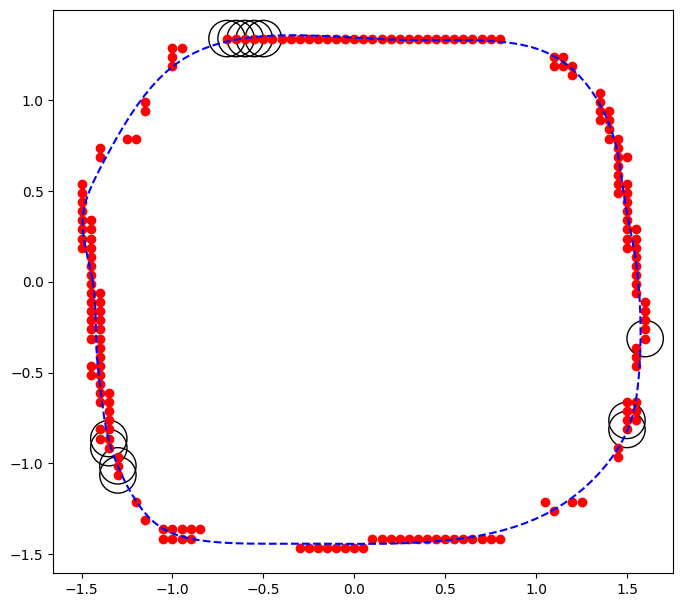

In [433]:
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

x = np.array(
      [[-0.50, -1.20],
       [-0.50, -1.15],
       [-0.50, -1.10],
       [-0.50, -1.05],
       [-0.50, -1.00],
       [-0.50, -0.95],
       [-0.50, -0.90],
       [-0.50, -0.85],
       [-0.45, -1.90],
       [-0.45, -1.85],
       [-0.45, -1.70],
       [-0.45, -1.65],
       [-0.45, -1.60],
       [-0.45, -1.55],
       [-0.45, -1.50],
       [-0.45, -1.45],
       [-0.45, -1.40],
       [-0.45, -1.35],
       [-0.45, -1.30],
       [-0.45, -1.25],
       [-0.45, -1.20],
       [-0.45, -1.15],
       [-0.45, -1.10],
       [-0.45, -1.05],
       [-0.40, -2.25],
       [-0.40, -2.20],
       [-0.40, -2.05],
       [-0.40, -2.00],
       [-0.40, -1.95],
       [-0.40, -1.90],
       [-0.40, -1.85],
       [-0.40, -1.80],
       [-0.40, -1.75],
       [-0.40, -1.70],
       [-0.40, -1.65],
       [-0.40, -1.60],
       [-0.40, -1.55],
       [-0.40, -1.50],
       [-0.40, -1.45],
       [-0.40, -0.70],
       [-0.40, -0.65],
       [-0.35, -2.30],
       [-0.35, -2.25],
       [-0.35, -2.20],
       [-0.35, -2.15],
       [-0.35, -2.10],
       [-0.35, -2.05],
       [-0.35, -2.00],
       [-0.30, -2.45],
       [-0.30, -2.40],
       [-0.30, -2.35],
       [-0.25, -0.60],
       [-0.20, -2.60],
       [-0.20, -0.60],
       [-0.15, -2.70],
       [-0.15, -0.45],
       [-0.15, -0.40],
       [-0.05, -2.80],
       [-0.05, -2.75],
       [0.00, -2.80],
       [0.00, -2.75],
       [0.00, -0.20],
       [0.00, -0.15],
       [0.00, -0.10],
       [0.05, -2.80],
       [0.05, -2.75],
       [0.05, -0.10],
       [0.10, -2.80],
       [0.10, -2.75],
       [0.15, -2.75],
       [0.30, -0.05],
       [0.35, -0.05],
       [0.40, -0.05],
       [0.45, -0.05],
       [0.50, -0.05],
       [0.55, -0.05],
       [0.60, -0.05],
       [0.65, -0.05],
       [0.70, -2.85],
       [0.70, -0.05],
       [0.75, -2.85],
       [0.75, -0.05],
       [0.80, -2.85],
       [0.80, -0.05],
       [0.85, -2.85],
       [0.85, -0.05],
       [0.90, -2.85],
       [0.90, -0.05],
       [0.95, -2.85],
       [0.95, -0.05],
       [1.00, -2.85],
       [1.00, -0.05],
       [1.05, -2.85],
       [1.05, -0.05],
       [1.10, -2.80],
       [1.10, -0.05],
       [1.15, -2.80],
       [1.15, -0.05],
       [1.20, -2.80],
       [1.20, -0.05],
       [1.25, -2.80],
       [1.25, -0.05],
       [1.30, -2.80],
       [1.30, -0.05],
       [1.35, -2.80],
       [1.35, -0.05],
       [1.40, -2.80],
       [1.40, -0.05],
       [1.45, -2.80],
       [1.45, -0.05],
       [1.50, -2.80],
       [1.50, -0.05],
       [1.55, -2.80],
       [1.55, -0.05],
       [1.60, -2.80],
       [1.60, -0.05],
       [1.65, -2.80],
       [1.65, -0.05],
       [1.70, -2.80],
       [1.70, -0.05],
       [1.75, -2.80],
       [1.75, -0.05],
       [1.80, -2.80],
       [1.80, -0.05],
       [2.05, -2.60],
       [2.10, -2.65],
       [2.10, -0.20],
       [2.10, -0.15],
       [2.15, -0.20],
       [2.15, -0.15],
       [2.20, -2.60],
       [2.20, -0.25],
       [2.20, -0.20],
       [2.25, -2.60],
       [2.35, -0.50],
       [2.35, -0.45],
       [2.35, -0.40],
       [2.35, -0.35],
       [2.40, -0.60],
       [2.40, -0.55],
       [2.40, -0.50],
       [2.40, -0.45],
       [2.45, -2.35],
       [2.45, -2.30],
       [2.45, -0.90],
       [2.45, -0.85],
       [2.45, -0.80],
       [2.45, -0.75],
       [2.45, -0.70],
       [2.45, -0.65],
       [2.45, -0.60],
       [2.50, -2.20],
       [2.50, -2.15],
       [2.50, -2.10],
       [2.50, -2.05],
       [2.50, -1.20],
       [2.50, -1.15],
       [2.50, -1.10],
       [2.50, -1.05],
       [2.50, -1.00],
       [2.50, -0.95],
       [2.50, -0.90],
       [2.50, -0.85],
       [2.50, -0.70],
       [2.55, -2.15],
       [2.55, -2.10],
       [2.55, -2.05],
       [2.55, -1.85],
       [2.55, -1.80],
       [2.55, -1.75],
       [2.55, -1.45],
       [2.55, -1.40],
       [2.55, -1.35],
       [2.55, -1.30],
       [2.55, -1.25],
       [2.55, -1.20],
       [2.55, -1.15],
       [2.55, -1.10],
       [2.60, -1.70],
       [2.60, -1.65],
       [2.60, -1.60],
       [2.60, -1.55],
       [2.60, -1.50]])

# points = x
# dist_stddev_thresh_multiplier = 2.0

# # Function to find angle of point from centroid
# def angle(point):
#       dx, dy = point - centroid
#       return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# # Sort the points based on their angles around the centroid
# sorted = points[np.argsort([angle(point) for point in points])]

xs = (x - x.mean(0))
sorted = xs[np.angle((xs[:,0] + 1j*xs[:,1])).argsort()]

# Get individual arrays for the points
x_data = sorted[:, 0]
y_data = sorted[:, 1]

# Fit spline to the data
tck, u = splprep([x_data, y_data], u=None, s=0.2, per=1)
# Plot the points
u_fit = np.linspace(u.min(), u.max(), len(points))
x_fit, y_fit = splev(u_fit, tck, der=0)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect(1)
ax.plot(sorted[:,0], sorted[:,1], 'ro')
ax.plot(x_fit, y_fit, 'b--')


# Calculate the distance between each point and its corresponding spline point
distances = (x_data - x_fit)**2 + (y_data - y_fit)**2

# Find the index of the point with the maximum distance
dist_thresh = np.mean(distances) + np.std(distances) * dist_stddev_thresh_multiplier
too_far_indicies = np.where(distances > dist_thresh)[0]

print(f'outliers: {too_far_indicies}')
for index in too_far_indicies:
      circle = plt.Circle((x_data[index], y_data[index]), 0.1, fill=False)
      ax.add_artist(circle)
plt.show()


In [269]:
xs = (x - x.mean(0))
x_sort = xs[np.angle((xs[:,0] + 1j*xs[:,1])).argsort()]

# Spline fitting

In [427]:
def fit_spline_and_remove_outliers(binary_image: np.ndarray, dist_stddev_thresh_multiplier: float) -> np.ndarray:

    labelled = label(binary_image)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid

    # Function to find angle of point from centroid
    def angle(point):
        dx, dy = point - centroid
        return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

    # Sort the points based on their angles around the centroid
    sorted = points[np.argsort([angle(point) for point in points])]

    # Get individual arrays for the points
    x_data = sorted[:, 0]
    y_data = sorted[:, 1]

    # Fit spline to the data
    tck, u = splprep([x_data, y_data], u=None, s=1000000, per=1)
    # Plot the points
    u_fit = np.linspace(u.min(), u.max(), len(points))
    x_fit, y_fit = splev(u_fit, tck, der=0)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect(1)
    ax.plot(sorted[:,0], sorted[:,1], 'ro')
    ax.plot(x_fit, y_fit, 'b--')


    # Calculate the distance between each point and its corresponding spline point
    distances = (x_data - x_fit)**2 + (y_data - y_fit)**2

    # Find the index of the point with the maximum distance
    dist_thresh = np.mean(distances) + np.std(distances) * dist_stddev_thresh_multiplier
    too_far_indicies = np.where(distances > dist_thresh)[0]

    print(f'outliers: {too_far_indicies}')
    for index in too_far_indicies:
        circle = plt.Circle((x_data[index], y_data[index]), 50, fill=False)
        ax.add_artist(circle)
    plt.show()

    # # Initialise image comparison plots
    # fig_img, ax_img = plt.subplots(1, 3, figsize=(14, 5))

    # # Plot residuals
    # ax_fit[1].scatter(x_data, distances)
    # ax_fit[1].set_xlim(0, 2000)
    # ax_fit[1].axhline(y=dist_thresh, color='r', linestyle='-')
    # ax_fit[1].axhline(y=-dist_thresh, color='r', linestyle='-')
    # ax_fit[1].set_title('residuals')

    # # Copy arrays for posterity
    # removed_too_far_points = label(binary_image.copy())
    # before_removal = removed_too_far_points.copy()

    # # Remove too far points
    # for index in too_far_indicies:
    #     removed_too_far_points[removed_too_far_points==index] = 0
    #     circle = plt.Circle((x_data[index-1], y_data[index-1]), 50, fill=False)
    #     ax_img[0].add_artist(circle)
    #     ax_fit[1].scatter(x_data[index-1], distances[index-1], marker='.', color='r') # Sub one since point indices start from zero
    #     ax_fit[0].scatter(x_data[index-1], y_data[index-1], marker='.', color='r')

    # # Plot results
    # ax_img[0].imshow(before_removal.astype(bool))
    # ax_img[0].set_title('before')
    # ax_img[1].imshow(removed_too_far_points.astype(bool))
    # ax_img[1].set_title('removed too far points')
    # ax_img[2].imshow((removed_too_far_points - before_removal).astype(bool))
    # ax_img[2].set_title('difference')
    # fig_img.suptitle(f'thresh={dist_stddev_thresh_multiplier}*std_dev + mean')
    # fig_img.tight_layout()


    # return removed_too_far_points


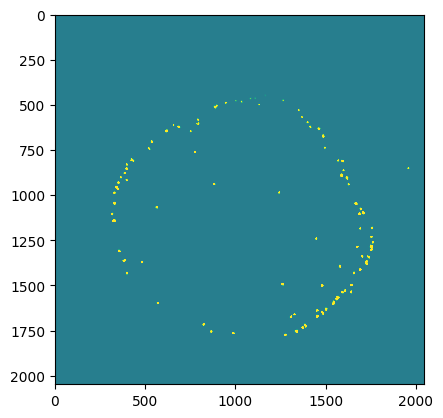

outliers: [84 85 87 88 89]


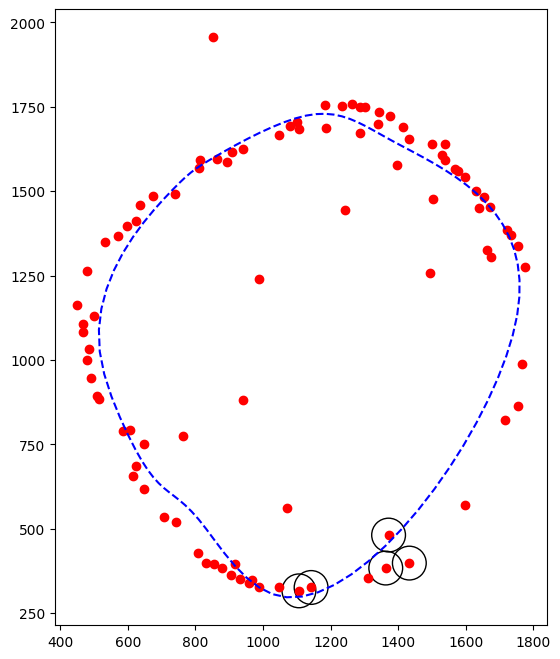

In [428]:
plot(labelled_rosette_mask)
fit_spline_and_remove_outliers(labelled_rosette_mask, dist_stddev_thresh_multiplier=2.0)
